# Práctica 2 - Generación de imágenes

Un autoencoder es una red de neuronas que está entrenada para intentar reproducir su entrada en la salida. Internamente consta de tres partes:
 1. Una red codificadora que obtiene un vector $\mathbf{h}$, de menor tamaño que la entrada.
 $$
 \mathbf{h}=f(\mathbf{x})
 $$
 $\mathbf{h}$ constituye una representación latente de la entrada. Esta representación latente debe contener la información de la entrada original para poder reconstruirla.
 1. Una red decodificadora que, a partir de $\mathbf{h}$, produce $\mathbf{\hat{x}}$.
 $$
 \mathbf{\mathbf{\hat{x}}}=f(\mathbf{h})
 $$
 El autoencoder al completo se entrenará para que $\mathbf{\hat{x}}$ reproduzca $\mathbf{x}$, para lo cual el vector $\mathbf{h}$ deberá contener la información contenida en $\mathbf{x}$, a pesar de ser de un tamaño mucho menor.
 
 ![Esquema de la arquitectura de un autoencoder](https://drive.google.com/uc?export=view&id=1I4IfrsCJDWBDiGYlUNGr4M-IP7Ehb2Mr)

## Tarea a realizar
Diseña un autoencoder convolucional que sea capaz de reconstruir imágenes y, en el proceso, aprenda a representar las imágenes originales en un espacio latente de dimensión reducida.

### Preparativos
Utilizaremos el dataset MNIST, del que solo necesitaremos las entradas (desechamos las etiquetas). Además, podemos aprovechar tanto el conjunto de train como el de test para el entrenamiento.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
# Descargamos el conjunto de datos
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
# Juntamos el conjunto de train y el de test en uno porque no los vamos a usar por separado
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

11490434/11490434 [==============================] - 1s 0us/step


## Pasos a seguir

### Diseño de la arquitectura `📋 1 punto`
  - Diseña una red convolucional que actúe de encoder. Debe tener alguna capa convolucional. La salida de este autoencoder será un vector con `dimension_h` componentes. En esta práctica tomaremos siempre `dimension_h`=2.

In [2]:
dimension_h = 2
kernel_size = 3
input_shape = (28, 28, 1)
activation = 'relu'
pool_size=(2, 2)

# Creamos el encoder
encoder_input = tf.keras.Input(shape=input_shape)
e = tf.keras.layers.Conv2D(filters = 16, kernel_size = kernel_size, activation = activation, padding='same')(encoder_input) #Paddin = 'same' es para que la salida tenga las mismas dimensiones que la de entrada
e = tf.keras.layers.MaxPooling2D(pool_size = pool_size)(e)
e = tf.keras.layers.Conv2D(filters = 32, kernel_size = kernel_size, activation = activation, padding='same')(e)
e = tf.keras.layers.MaxPooling2D(pool_size = pool_size)(e)
e = tf.keras.layers.Flatten()(e)
e = tf.keras.layers.Dense(units=dimension_h, activation='softmax')(e) #Le indicamos que queremos una salida de dimensión 2
encoder = tf.keras.Model(encoder_input, e, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1568)              0   

  - Diseña una red convolucional que actúe de decoder. Su arquitectura será similar a la del encoder, pero utilizando capas complementarias a las convolucionales [(Conv2DTranspose)](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/). La entrada a este decoder será un vector de tamaño dimension_latente. La salida tendrá la misma shape que la entrada del encoder.

In [3]:
# Creamos el decoder de manera simética al encoder
decoder_input = tf.keras.Input(shape=(dimension_h,)) # Entrada de dimensión latente
d = tf.keras.layers.Dense(units = 1568, activation = activation)(decoder_input)
d = tf.keras.layers.Reshape((7,7,32))(d)
d = tf.keras.layers.UpSampling2D(size = pool_size)(d)
d = tf.keras.layers.Conv2DTranspose(filters = 16, kernel_size = kernel_size, activation = activation, padding='same')(d)
d = tf.keras.layers.UpSampling2D(size = pool_size)(d)
d = tf.keras.layers.Conv2DTranspose(filters = 1, kernel_size = kernel_size, activation = activation, padding='same')(d)
decoder = tf.keras.Model(decoder_input, d, name='decoder') # Salida del tamaño de la imagen original
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 1568)              4704      
                                                                 
 reshape (Reshape)           (None, 7, 7, 32)          0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 16)       4624      
 nspose)                                                         
                                                                 
 up_sampling2d_1 (UpSampling  (None, 28, 28, 16)       0   

  - Diseña el modelo del autoencoder completo concatenando el encoder y el decoder.
  - Compila el modelo indicando un optimizador y función de pérdida que consideres apropiados.

In [ ]:
# Creamos el autoencoder
auto_input = tf.keras.Input(shape=input_shape)
a = encoder(auto_input)
aut_outputs = decoder(a)
autoencoder = tf.keras.Model(auto_input, aut_outputs, name='autoencoder')
autoencoder.summary()

# Definimos la función de pérdida y el optimizador y compilamos
fn_perdida = tf.keras.losses.MeanSquaredError()
optimizador = tf.keras.optimizers.SGD()
autoencoder.compile(loss=fn_perdida, optimizer=optimizador)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 2)                 7938      
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         9473      
                                                                 
Total params: 17,411
Trainable params: 17,411
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento `📋 1 punto`
  - Entrena el modelo completo durante 30 epochs. Especifica un tamaño de lote de 128.

In [ ]:
import os
import random
#Poñemos unha semente para obter resultados estables
seed=1234
os.environ['PYTHONHASHSEED']=str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
# Indicamos las repeticiones y el tamaño de lote pedidos
num_epochs = 30
batch_size = 128
history = autoencoder.fit(x = mnist_digits, y = mnist_digits, batch_size = batch_size, epochs = num_epochs)

Epoch 1/30
547/547 [==============================] - 6s 6ms/step - loss: 0.0883
Epoch 2/30
547/547 [==============================] - 3s 5ms/step - loss: 0.0752
Epoch 3/30
547/547 [==============================] - 3s 5ms/step - loss: 0.0696
Epoch 4/30
547/547 [==============================] - 3s 5ms/step - loss: 0.0683
Epoch 5/30
547/547 [==============================] - 3s 5ms/step - loss: 0.0679
Epoch 6/30
547/547 [==============================] - 3s 5ms/step - loss: 0.0675
Epoch 7/30
547/547 [==============================] - 3s 5ms/step - loss: 0.0673
Epoch 8/30
547/547 [==============================] - 3s 5ms/step - loss: 0.0670
Epoch 9/30
547/547 [==============================] - 3s 5ms/step - loss: 0.0667
Epoch 10/30
547/547 [==============================] - 3s 5ms/step - loss: 0.0664
Epoch 11/30
547/547 [==============================] - 3s 5ms/step - loss: 0.0659
Epoch 12/30
547/547 [==============================] - 3s 5ms/step - loss: 0.0654
Epoch 13/30
547/547 [====

¡Tu modelo ya está entrenado! Si todo ha ido bien, el modelo es capaz de resumir cada imagen en `dimension_h`=2 valores que contienen toda la información necesaria para reconstruir la imagen original.

Además, para cualquier par de números $(h_0,h_1)$, el decoder es capaz de generar una imagen similar a las del conjunto de entrenamiento. Podemos utilizar esta característica para generar nuevas imágenes, simplemente pasándole al encoder un par de números cualesquiera.

En lugar de probar valores aleatorios, vamos a explorar el espacio latente de manera ordenada. Para ello daremos valores entre -1 y 1 a las dos variables latentes y comprobaremos qué imagen produce el decoder cuando se le proporciona esa entrada.

In [4]:
import matplotlib.pyplot as plt

def genera_entramado_imagenes(decoder, shape_imagen, limites_exploracion=[-1,1], escala=15, pasos=30):
    '''
    Esta función crea un entramado de nxn imágenes donde cada una es el resultado de
    aplicar el decoder pasado como parámetro a un vector [x,y], donde x e y recorren el espacio entre -1 y
    1 utilizando incrementos para cubrirlo uniformemente.
    '''
    alto_imagen = shape_imagen[0]
    ancho_imagen = shape_imagen[1]

    # Tendremos un solo array donde iremos guardando las imágenes generadas
    imagen_general = np.zeros((alto_imagen * pasos, ancho_imagen * pasos))

    for i in range(pasos):
        for j in range(pasos):
            # Calculamos el valor h para pasarle al decoder
            h0 = limites_exploracion[0] + (limites_exploracion[1]-limites_exploracion[0])*i/pasos
            h1 = limites_exploracion[0] + (limites_exploracion[1]-limites_exploracion[0])*j/pasos
            h = np.array([[h0, h1]])
            # Generamos la imagen a partir del valor h
            imagen_generada = decoder.predict(h, verbose=0)
            imagen_generada = imagen_generada[0].reshape(alto_imagen, ancho_imagen)
            # Guardamos la imagen en la imagen general
            imagen_general[i * alto_imagen : (i+1) * alto_imagen, j * ancho_imagen : (j+1) * ancho_imagen] = imagen_generada

    # Mostramos un plot con la imagen general
    plt.figure(figsize=(escala, escala))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.xlabel("h0")
    plt.ylabel("h1")
    plt.imshow(imagen_general, cmap="Greys_r")
    plt.show()

  - Lanza la función para que explore el espacio con tu decoder.

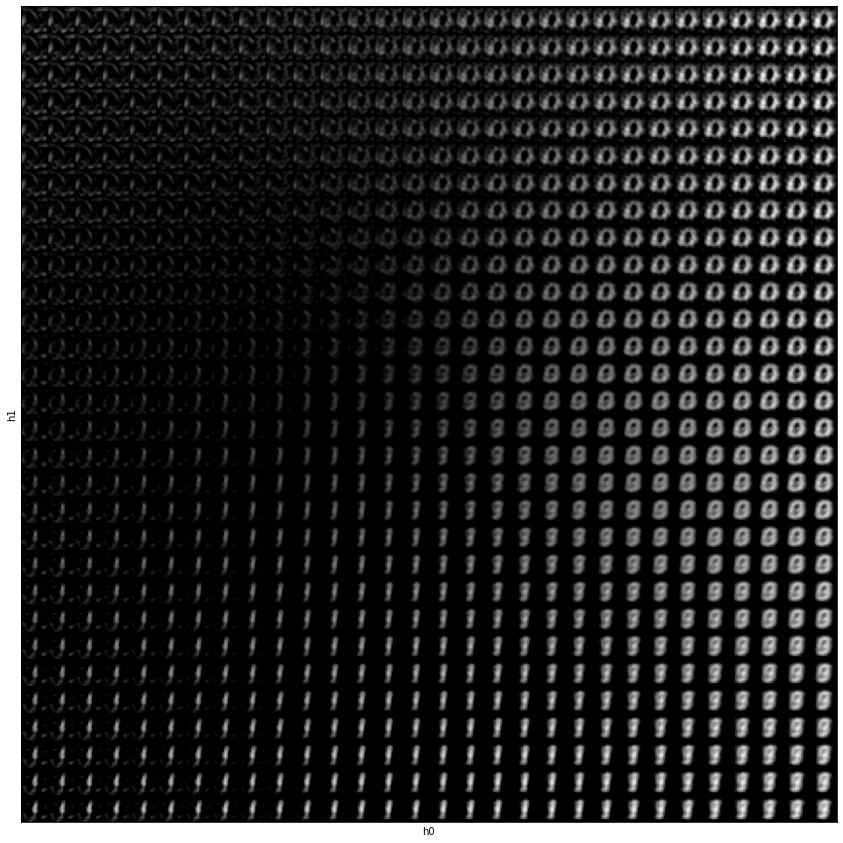

In [ ]:
genera_entramado_imagenes(decoder, input_shape, limites_exploracion=[-1,1], escala=15, pasos=30)

Puedes comprobar que, aunque hay muchas imágenes que representan números correctamente, hay grandes regiones del espacio latente que producen imágenes sin sentido. Esto es así porque los espacios aprendidos por los autoencoder no tienen por qué ser continuos. Para obtener un autoencoder que favorezca este tipo de exploración tenemos que añadir una restricción que fuerce a que el espacio latente tenga una forma determinada.

## Mejora de la explorabilidad del espacio latente
Diseña un nuevo autoencoder con una restricción adicional: **cada variable $h_i$ de la representación latente debe seguir una distribución gaussiana**.

Para ello, por cada variable latente, el encoder producirá dos escalares, $hm_i$ y $hs_i$ que harán las veces de media y desviación típica de dicha variable latente. Con estos parámetros, se tomará una muestra aleatoria de cada distribución para obtener el vector latente que sirva de entrada al decoder.
$$h_i \sim N(hm_i, hs_i)$$ Utiliza la funcion `tf.keras.backend.random_normal`, que muestrea números $$z \sim N(0, 1)$$ a partir del cual puedes generar $h_i$ como $$h_i=hm_i + z*hs_i$$
Nota: Por razones de estabilidad numérica, puede ser conveniente que tomes $hs_i$ como el logaritmo de la varianza, en lugar de como la desviación típica. En ese caso, puedes generar $h_i$ así: $$h_i=hm_i + z*e^{(hs_i/2)}$$

![Esquema de la arquitectura de un autoencoder](https://drive.google.com/uc?export=view&id=1i7ADJ0ilUk-lqYa_Qv9_b2sIVJkx_aaS)

## Pasos a seguir

### Diseño de la arquitectura
  - Diseña un nuevo encoder. También debe tener alguna capa convolucional, pero ahora las salidas de este autoencoder serán 2 * dimension_latente valores escalares. `📋 0.5 puntos`
  - Diseña una capa que, a partir de las medias hm y desviaciones hs de cada variable, genere el vector h. `📋 2 puntos`

In [5]:
# Definimos una clase Sampling que hereda de la clase de layers que lo que hace es juntar las dos capas de media y desviación
# típica en una sola usando la fórmula indicada arriba en el enunciado
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        hm, hs = inputs #separamos el input en las variables que nos interesan
        batch = tf.shape(hm)[0] #Nos quedamos con las dimensiones de las variables para poder indicarlo abajo
        dim = tf.shape(hm)[1]
        z = tf.keras.backend.random_normal(shape=(batch, dim)) # muestreamos los números de una N(0,1) con la misma dimensión que hm y hs
        return hm + tf.exp(0.5 * hs) * z # devolvemos el resultado de la fórmula 

inputs = tf.keras.Input(shape=(input_shape))
en_m = tf.keras.layers.Conv2D(filters = 32, kernel_size = kernel_size, activation = activation, padding='same')(inputs) # Se usa padding = 'same' para que la imagen de salida sea de las mismas dimensiones que la de entrada
en_m = tf.keras.layers.Conv2D(filters = 8, kernel_size = kernel_size, activation = activation, padding='same')(en_m)
en_m = tf.keras.layers.Flatten()(en_m)
en_m = tf.keras.layers.Dense(units=dimension_h, activation='softmax')(en_m)
mean = tf.keras.layers.Dense(dimension_h, name='media')(en_m) # Aquí obtenemos de la capa anterior una Dense que va a hacer de media
std = tf.keras.layers.Dense(dimension_h, name='desviacion_tipica')(en_m) # Aquí obtenemos de la capa anterior una Dense que va a hacer de desviación típica
z = Sampling()([mean, std]) # Con esto juntamos los dos resultados anteriores en una sola capa aplicando la fórmula de arriba
encoder_mejorado = tf.keras.Model(inputs, [z, mean, std], name='encoder_mejorado')

encoder_mejorado.summary()

Model: "encoder_mejorado"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 28, 28, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 28, 28, 8)    2312        ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 6272)         0           ['conv2d_3[0][0]']               
                                                                                   

  - Haz los cambios que consideres pertinentes en el decoder.  `📋 0.5 puntos`

In [6]:
# El decoder queda igual que como el normal, porque no nos interesa que haga la operación inversa y pase por la media y desviación típica
decoder_input = tf.keras.Input(shape=(dimension_h,))
d_m = tf.keras.layers.Dense(units = 392, activation = activation)(decoder_input)
d_m = tf.keras.layers.Reshape((7,7,8))(d_m)  
d_m = tf.keras.layers.UpSampling2D(size = pool_size)(d_m)
d_m = tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size = kernel_size, activation = activation, padding='same')(d_m)
d_m = tf.keras.layers.UpSampling2D(size = pool_size)(d_m)
d_m = tf.keras.layers.Conv2DTranspose(filters = 1, kernel_size = kernel_size, activation = activation, padding='same')(d_m)
decoder_mejorado = tf.keras.Model(decoder_input, d_m, name='decoder')
decoder_mejorado.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 392)               1176      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 8)           0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 32)       2336      
 ranspose)                                                       
                                                                 
 up_sampling2d_3 (UpSampling  (None, 28, 28, 32)       0   

  - Diseña el modelo completo y altera el train_step para que la función de pérdida, además del error de reconstrucción, tenga en cuenta la KL-divergence con una N(0,1)
  - La fórmula para la KL-divergence entre dos distribuciones $p=N(\mu_1,\sigma_1)$ y $q=N(\mu_2,\sigma_2)$ es la siguiente:
  $$KL(p,q) = \log{\frac{\sigma_2}{\sigma_1}}+\frac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-\frac{1}{2}$$

In [7]:
# train-step modificado
class CustomTrainStepModel(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder 
        self.decoder = decoder
        # Definimos el contenedor donde vamos a ir guardando las diferentes pérdidas
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.rec_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
      return inputs
 
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.rec_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Se pasan por encoder y decoder
            y, mean, std = self.encoder(data) # de aquí obtenemos la media y la deviación típica
            rec = self.decoder(y)
            # Pérdida de reconstrucción con la función de pérdida que se le indica
            loss_rec = tf.reduce_mean(tf.reduce_sum(self.compiled_loss(data, rec, regularization_losses=self.losses)))
            # Pérdida de KL-Divergent
            kl_loss_vectores = tf.math.log(1/std) + (std**2 + mean**2)/2 - 0.5
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss_vectores))
            # Pérdida total
            loss = loss_rec + kl_loss

        # Actualizamos todos los losses
        self.total_loss_tracker.update_state(loss)
        self.rec_loss_tracker.update_state(loss_rec)
        self.kl_loss_tracker.update_state(kl_loss)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
  
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.rec_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

autoencoder_mejorado = CustomTrainStepModel(encoder_mejorado, decoder_mejorado) #Aqui cambia la manera de llamar al modelo para que luego el fit use el train_Step que indicamos nosotros
input_shape = (28, 28, 1)
autoencoder_mejorado.build(input_shape)
autoencoder_mejorado.summary()

Model: "custom_train_step_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_mejorado (Functiona  [(None, 2),              15190     
 l)                           (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         3801      
                                                                 
Total params: 18,997
Trainable params: 18,991
Non-trainable params: 6
_________________________________________________________________


In [8]:
fn_perdida_mejorado = tf.keras.losses.MeanSquaredError() 
optimizador_mejorado = tf.keras.optimizers.Adam(learning_rate = 0.0001)
autoencoder_mejorado.compile(loss=fn_perdida_mejorado, optimizer=optimizador_mejorado)

  - Entrena el modelo  `📋 2 puntos`

In [9]:
import os
import random
#Poñemos unha semente para obter resultados estables
seed=1234
os.environ['PYTHONHASHSEED']=str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

num_epochs = 30
batch_size = 128

history = autoencoder_mejorado.fit(x = mnist_digits, batch_size = batch_size, epochs = num_epochs)

Epoch 1/30
547/547 [==============================] - 13s 7ms/step - loss: nan - reconstruction_loss: 0.0811 - kl_loss: nan
Epoch 2/30
547/547 [==============================] - 4s 8ms/step - loss: 58.0995 - reconstruction_loss: 0.0688 - kl_loss: 52.2433
Epoch 3/30
547/547 [==============================] - 4s 7ms/step - loss: 37.5430 - reconstruction_loss: 0.0681 - kl_loss: 33.6118
Epoch 4/30
547/547 [==============================] - 4s 7ms/step - loss: 23.6975 - reconstruction_loss: 0.0679 - kl_loss: 20.9988
Epoch 5/30
547/547 [==============================] - 4s 7ms/step - loss: 14.3073 - reconstruction_loss: 0.0678 - kl_loss: 12.4851
Epoch 6/30
547/547 [==============================] - 4s 7ms/step - loss: 8.1139 - reconstruction_loss: 0.0677 - kl_loss: 6.9302
Epoch 7/30
547/547 [==============================] - 4s 7ms/step - loss: 4.2426 - reconstruction_loss: 0.0676 - kl_loss: 3.5150
Epoch 8/30
547/547 [==============================] - 4s 7ms/step - loss: 2.0087 - reconstruct

  - Explora el espacio latente con este nuevo decoder

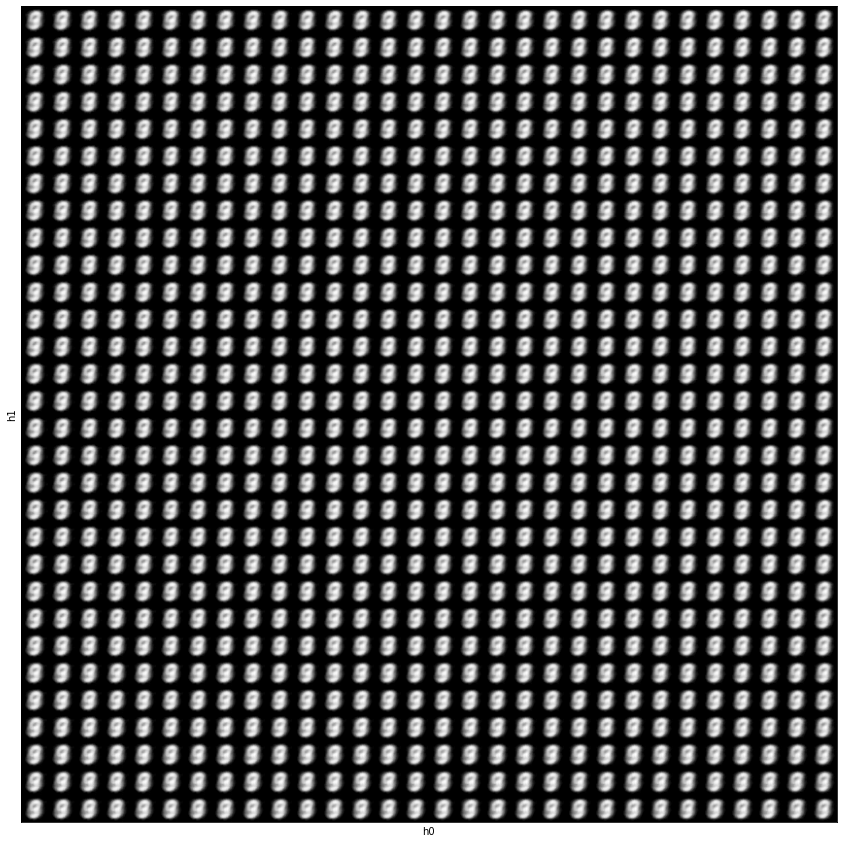

In [10]:
genera_entramado_imagenes(decoder_mejorado, input_shape, limites_exploracion=[-1,1], escala=15, pasos=30)

# Adaptación a otro conjunto de datos

Modifica tu generador de imágenes para que funcione con el conjunto de datos CIFAR10. `📋 3 puntos`

In [ ]:
# Descargamos el conjunto de datos
(x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()
cifar10 = np.concatenate([x_train, x_test], axis=0)
cifar10 = np.expand_dims(cifar10, -1).astype("float32") / 255
cifar10 = cifar10.reshape((cifar10.shape[0],) + (32,32,3))
# Vemos cuales son las dimensiones de cada imagen
from numpy.ma.core import shape
print(shape(cifar10[0]))

(32, 32, 3)


In [ ]:
cif_input_shape = (32, 32, 3)
cif_dim_h = 3

inputs = tf.keras.Input(shape=cif_input_shape)
ec = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding='same')(inputs)
ec = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(ec)
ec = tf.keras.layers.Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu', padding='same')(ec)
ec = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(ec)
ec = tf.keras.layers.Flatten()(ec)
ec = tf.keras.layers.Dense(units=cif_dim_h, activation='softmax')(ec)
mean_c = tf.keras.layers.Dense(cif_dim_h, name='media')(ec)
std_c = tf.keras.layers.Dense(cif_dim_h, name='desviacion_tipica')(ec)
z_c = Sampling()([mean_c, std_c])
encoder_cifar = tf.keras.Model(inputs, [z_c, mean_c, std_c], name='encoder_cifar')
encoder_cifar.summary()

Model: "encoder_cifar"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 32, 32, 32)   896         ['input_5[0][0]']                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 16, 16, 32)  0           ['conv2d_4[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 16, 16, 8)    2312        ['max_pooling2d_4[0][0]']        
                                                                                      

In [ ]:
decoder_input = tf.keras.Input(shape=(cif_dim_h,))
dc = tf.keras.layers.Dense(units = 512, activation = 'relu')(decoder_input)
dc = tf.keras.layers.Reshape((8,8,8))(dc)  
dc = tf.keras.layers.UpSampling2D(size = (2,2))(dc)
dc = tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size = (3,3), activation = 'relu', padding='same')(dc)
dc = tf.keras.layers.UpSampling2D(size = (2,2))(dc)
dc = tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size = (3,3), activation = 'relu', padding='same')(dc)
decoder_cifar = tf.keras.Model(decoder_input, dc, name='decoder')
decoder_cifar.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_5 (Dense)             (None, 512)               2048      
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 8)           0         
                                                                 
 up_sampling2d_4 (UpSampling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 32)       2336      
 ranspose)                                                       
                                                                 
 up_sampling2d_5 (UpSampling  (None, 32, 32, 32)       0   

In [ ]:
autoencoder_cifar = CustomTrainStepModel(encoder_cifar, decoder_cifar)  
autoencoder_cifar.build(cif_input_shape)
autoencoder_cifar.summary()

Model: "custom_train_step_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_cifar (Functional)  [(None, 3),               4771      
                              (None, 3),                         
                              (None, 3)]                         
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         5251      
                                                                 
Total params: 10,028
Trainable params: 10,022
Non-trainable params: 6
_________________________________________________________________


In [ ]:
batch_size = 128
num_epochs = 30
fn_perdida_cifar = tf.keras.losses.MeanSquaredError()
optimizador_cifar = tf.keras.optimizers.Adam()
autoencoder_cifar.compile(loss=fn_perdida_cifar, optimizer=optimizador_cifar)
history = autoencoder_cifar.fit(x = cifar10, batch_size = batch_size, epochs = num_epochs)

Epoch 1/30
469/469 [==============================] - 12s 8ms/step - loss: nan - reconstruction_loss: 0.0716 - kl_loss: nan
Epoch 2/30
469/469 [==============================] - 4s 9ms/step - loss: 18.3005 - reconstruction_loss: 0.0623 - kl_loss: 11.7432
Epoch 3/30
469/469 [==============================] - 3s 7ms/step - loss: 2.0178 - reconstruction_loss: 0.0622 - kl_loss: 1.1786
Epoch 4/30
469/469 [==============================] - 3s 7ms/step - loss: 0.2100 - reconstruction_loss: 0.0622 - kl_loss: 0.0942
Epoch 5/30
469/469 [==============================] - 3s 7ms/step - loss: 0.0929 - reconstruction_loss: 0.0621 - kl_loss: 0.0274
Epoch 6/30
469/469 [==============================] - 3s 7ms/step - loss: 0.0843 - reconstruction_loss: 0.0621 - kl_loss: 0.0207
Epoch 7/30
469/469 [==============================] - 3s 7ms/step - loss: 0.0793 - reconstruction_loss: 0.0621 - kl_loss: 0.0162
Epoch 8/30
469/469 [==============================] - 3s 7ms/step - loss: 0.0756 - reconstruction_lo

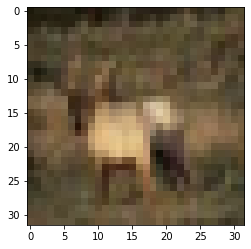

In [ ]:
# Mostramos una imagen
import matplotlib.pyplot as plt
plt.imshow(cifar10[3])

1/1 [==============================] - 0s 15ms/step


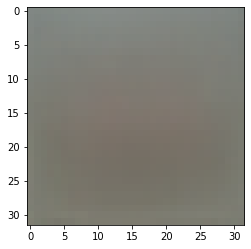

In [ ]:
# Mostramos la reconstrucción de la imagen de arriba
imagen = cifar10[3].reshape((1,32,32,3))
y = encoder_cifar.predict(imagen)
reconstruccion_cifar = decoder_cifar.predict(y[0])
rec = reconstruccion_cifar.reshape((32, 32, 3))
plt.imshow(rec)